In [1]:
import pickle
import warnings
from IPython.display import Image, HTML

import pandas as pd
import numpy as np
from scipy.stats import norm, uniform
import pymc3 as pm
from theano import shared

import seaborn as sb
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import ticker as mtick
import cmocean.cm as cmo

rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['legend.fontsize'] = 16
rcParams['xtick.minor.visible'] = True

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore',  category=FutureWarning)

In [3]:
def make_lower_triangle(gs):
    for i, j in zip(*np.triu_indices_from(gs.axes, 1)):
        gs.axes[i, j].set_visible(False)
    gs.axes[0,0].set_xlabel(gs.axes[0,0].get_ylabel())
    gs.axes[0,0].set_ylabel('')
    gs.axes[0,0].set_yticks([])

## <center><u>Probabilistic Programming for the Busy Modeler</u></center>

#### <font color='purple'><u>Motivation:</u></font>
* Transparent model building
    * assumptions are visible and verifiable
    * models are criticizable and can be improved upon iteratively
    * models are reproducible
    
    
* Generative models
    * data generating processes can be simulated
    * model assumptions can be checked and corrected
    * fit models can be understood through counterfactuals
    * out-of-sample data can be predicted

* Use of Probability
    * Uncertainty estimation
    * Information theory for modeling choices, model selection, ...

* Reduce overfitting risk
    * built-in regularization
    * maintain model predictive performance after deployment

* From small noisy data sets $\rightarrow$ global prediction
* Global or regional models?

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    $\rightarrow$The basics<br>
    $\rightarrow$Starting easy: inferring chlorophyll distribution<br>
    $\rightarrow$Regression: adding a predictor
* <font color='green'> Probabilistic modeling for the not-so-beginner<br>
    $\rightarrow$More complicated models<br>
    $\rightarrow$Empirical vs. semi-analytical: a useful dichotomy?<br>
    $\rightarrow$Causality and the backdoor criterion<br>
    $\rightarrow$Comparing models through information theory<br>
    $\rightarrow$Hierarchical probabilistic models</font><br>

##### Probabilistic modeling for the beginner
* The basics
* Starting easy: Inferring chlorophyll distribution
    * Grid approximation: computing probability everywhere
    * MCMC: how it works
    * PyMC3: MCMC on steroids
* Regression: Adding a predictor
    * Does my prior make sense?
    * The posterior as a gold mine
    * Different flavors of uncertainty

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    <font color='red'>$\rightarrow$The basics</font><br>
    $\rightarrow$Mechanistic introduction: inferring chlorophyll distribution<br>
    $\rightarrow$Regression: adding a predictor to estimate chlorophyll

#### The Basics: 
* Joint probability of two events $A$, $B$:
<br>
$$P(A, B)=P(A|B)\times P(B)=P(B|A)\times P(A)$$

* Inverse probability:$$\boxed{P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}}$$ 

* A, B independent: $$P(A|B) = P(A)\ \leftrightarrow P(A,B) = P(A)\times P(B)$$

* Log Probability:
$$\prod_i P(x_i) = e^{\sum_i{log(P(x_i))}}$$

#### The Basics: 
* extend joint probability to ($H$)ypothesis (<br>
    $\rightarrow$here H represents values that model parameters might take
* formulate initial opinion on what $H$ might include and with what probability, $P(H)$
* collect $D$ 
* update $P(H)$ using $D$ and Bayes' theorem


$$\frac{P(H)\times P(D|H)}{P(D)} = P(H|D)$$ 

#### The Basics: extending Bayes' theorem to building models informed by data

* Hypotheses ($H$): values that a given model's parameters might take
    * naive in the extreme: $H \in (-\infty, \infty)$, with equal probability everywhere
    * informative: results in reasonable model output
* formulate initial opinion on what $H$ might include and with what probability, $P(H)$
* collect data ($D$) 
* update $P(H)$ using $D$ and inverse probability (Bayes' theorem)


$$\frac{P(H)\times P(D|H)}{P(D)} = P(H|D)$$ 

$$ P(H) \times P(D|H) \propto P(H|D)$$

#### The Basics

$$\underline{P(H)}\times P(D|H) \propto P(H|D)$$
$P(H)$, the prior:
* $H$: set of values that model parameters might take with corresponding probability
* h=x & p(h=x)
* use a probability distribution to express $P(H)$

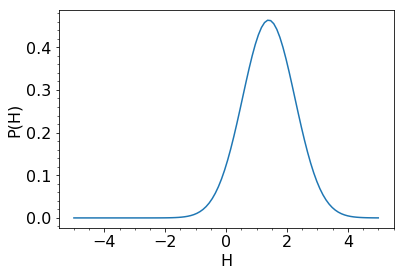

In [4]:
# build 1D grid of possible values
h = np.linspace(-5, 5, num=100)
μ_prior = 1.4 
σ_prior = 0.86
# compute probability at each a h
p_h = norm.pdf(h, loc=μ_prior, scale=σ_prior) 
pl.plot(h, p_h); pl.ylabel('P(H)'); pl.xlabel('H');

#### The Basics

$$P(H)\times \underline{P(D|H)} \propto  P(H|D)$$
$P(D|H)$, the likelihood:

* probability of the data, $D$, *given* $H$
* classically maximized$\rightarrow$best fit $\rightarrow$NOT DONE HERE!
* data may misrepresent the big picture

#### The Basics

$$P(H)\times P(D|H) \propto \underline{P(H|D)}$$
$P(H|D)$, the posterior:

* it's what we're after!!!
* updated probability of $H$ after collecting $D$
* used as prior for next iteration $P(H|D)\rightarrow P(H)$
* $P(H|D)$ naturally yields uncertainty

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    $\rightarrow$~~The basics~~<br>
    <font color='red'>$\rightarrow$Mechanistic introduction: inferring chlorophyll distribution</font><br>
    $\rightarrow$Regression land: adding a predictor

#### <font color='red'>Mechanistic introduction: Inferring chlorophyll distribution parameters</font>
* Grid approximation: computing probability for all parameter values
* Magical MCMC: how it works
* PyMC3: industrial grade MCMC

#### <font color='red'>Mechanistic introduction: Inferring chlorophyll distribution parameters</font>
* <font color='red'>Grid approximation: computing probability for all parameter values</font><br>
$\rightarrow$mechanistically straightforward<br>
$\rightarrow$computationally expensive!
* Magical MCMC: how it works
* PyMC3: industrial grade MCMC

In [5]:
df_data = pd.read_pickle('./pickleJar/df_logMxBlues.pkl')

In [6]:
df_data.insert(df_data.columns.get_loc('mxBlId'), 'mxBlId2',
           df_data.loc[:, ['rrs443_l', 'rrs510_l']].idxmax(axis=1).str.replace('_l', ''))

df_data.insert(df_data.columns.get_loc('MxBl-Gr'), 'MxBl-Gr2',
          df_data.loc[:, ['rrs443_l', 'rrs510_l']].max(axis=1) - df_data.loc[:, 'rrs555_l'])

df_data.head().T

,0,1,2,3,4
rrs411_l,-2.48181,-2.69759,-2.57346,-2.74698,-2.85684
rrs443_l,-2.39369,-2.57914,-2.48391,-2.66945,-2.77425
rrs489_l,-2.32961,-2.44558,-2.39021,-2.56902,-2.6778
rrs510_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.70144
rrs555_l,-2.26695,-2.36376,-2.34046,-2.59924,-2.80625
rrs670_l,-3.07818,-3.13471,-3.16042,-3.50443,-3.79611
mxBl_l,-2.29265,-2.38804,-2.36096,-2.5593,-2.6778
mxBlId2,rrs510,rrs510,rrs510,rrs510,rrs510
mxBlId,rrs510,rrs510,rrs510,rrs510,rrs489
MxBl-Gr2,-0.0257098,-0.0242776,-0.0205022,0.0399411,0.104812


In [7]:
df_data[['MxBl-Gr', 'chl_l']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4459 entries, 0 to 4458
Data columns (total 2 columns):
MxBl-Gr    4453 non-null float64
chl_l      4127 non-null float64
dtypes: float64(2)
memory usage: 104.5 KB


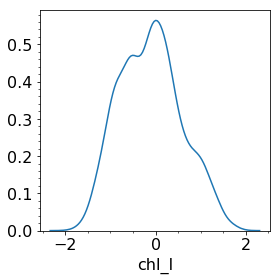

In [8]:
f, ax = pl.subplots(figsize=(4,4))
sb.kdeplot(df_data.chl_l, ax=ax, legend=False);
ax.set_xlabel('chl_l');
f.tight_layout()
f.savefig('./figJar/Presentation/fig1_chl.svg', dpi=300, format='svg')

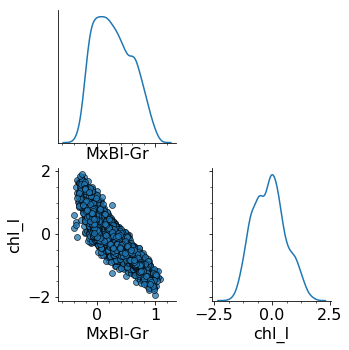

In [9]:
g = sb.PairGrid(df_data.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
f = pl.gcf()
f1 = './figJar/Presentation/fig1_pairwise.svg'
f.savefig(f1, format='svg', dpi=300)

#### Grid approximation:
 * Inferring chlorophyll distribution parameters
 * Choose a distribution
 * Set the grid
 * <u>Propose priors</u>
 * <u>Compute likelihood</u>
 * <u>Compute posterior</u>

<center><img src='./figJar/Presentation/fig1_chl.svg', width=400px, height=400px></center>

#### Grid approximation

* model using Gaussian
* Hypotheses concern the mean $\mu$, and the standard deviation, $\sigma$
* create a 2D grid of possible $\mu$ and $\sigma$ 
* define priors for both $\mu$ and $\sigma$
* compute likelihood
* compute posterior 

<img src='./figJar/Presentation/tutorial_1_1.png' height=50>

Define grid with axes $\mu$(mean) and $\sigma$ (std. dev.)

In [10]:
μ = np.linspace(-2, 2, num=200) # μ-axis
σ = np.linspace(0, 2, num=200) # σ-axis

In [11]:
df_grid = pd.DataFrame([[μ_i, σ_i]
                        for σ_i in σ for μ_i in μ],
                        columns=['μ', 'σ'])

In [12]:
print(df_grid.shape)
df_grid.head(7)

(40000, 2)


,μ,σ
0,-2.000000,0.0
1,-1.979899,0.0
2,-1.959799,0.0
3,-1.939698,0.0
4,-1.919598,0.0
5,-1.899497,0.0
6,-1.879397,0.0


#### Define prior probability distributions for $\mu$ and $\sigma$ 
* $\mu \sim \mathcal{N}(1, 1)$: a gaussian distribution centered at 1, with an sd of 1
* $\sigma \sim \mathcal{U}(0, 2)$: a uniform distribution between 0 and 2

In [13]:
μ_prior = norm.logpdf(df_grid.μ, 1, 1)
σ_prior = uniform.logpdf(df_grid.σ, 0, 2)

<img src="./figJar/Presentation/tutorial_1_2.png">

#### Compute multi-dimensional prior probability

In [14]:
# log prior probability
df_grid['log_prior_prob'] = μ_prior + σ_prior
# straight prior probability
df_grid['prior_prob'] = np.exp(df_grid.log_prior_prob
                                - df_grid.log_prior_prob.max())

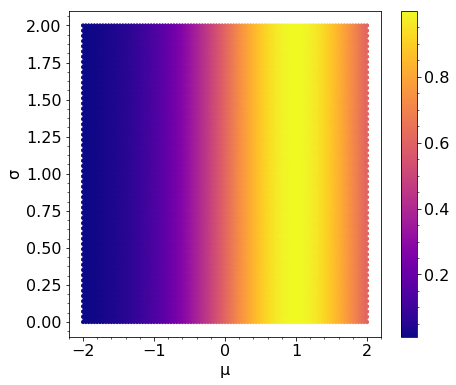

In [15]:
df_grid.plot.hexbin(x='μ', y='σ', C='prior_prob', figsize=(7,6),
                     cmap='plasma', sharex=False);


#### Bring in data 

$\Rightarrow$Subsample the data<br>
$\ \ \ \rightarrow$computationally more tractable for grid approximation<br>
$\ \ \ \rightarrow$show the impact of prior choice

In [16]:
sample_N = 10
df_data_s = df_data.dropna().sample(n=sample_N)

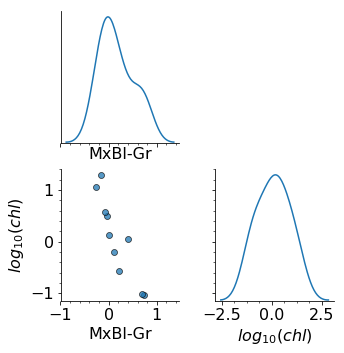

In [17]:
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

#### Compute Log-Likelihood of the data given every  pair $(\mu,\sigma)$ 

In [18]:
df_grid['LL'] = np.sum(norm.logpdf(df_data_s.chl_l.values.reshape(1, -1),
                                    loc=df_grid.μ.values.reshape(-1, 1),
                                    scale=df_grid.σ.values.reshape(-1, 1)
                                   ), axis=1)

#### Compute Posterior $P(\mu,\sigma\ | data) \propto P(data | \mu, \sigma) \times P(\mu, \sigma)$

In [19]:
# compute log-probability
df_grid['log_post_prob'] = df_grid.LL + df_grid.log_prior_prob
# convert to straight prob.
df_grid['post_prob'] = np.exp(df_grid.log_post_prob
                               - df_grid.log_post_prob.max())

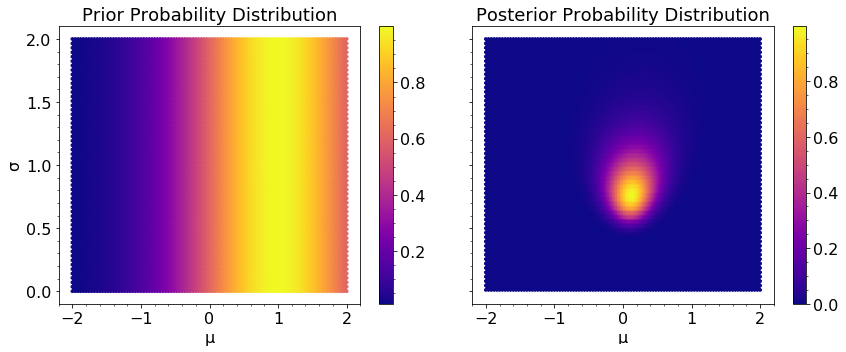

In [20]:
# Plot Multi-Dimensional Prior and Posterior
f, ax = pl.subplots(ncols=2, figsize=(12, 5), sharey=True)
df_grid.plot.hexbin(x='μ', y='σ', C='prior_prob',
                    cmap='plasma', sharex=False, ax=ax[0])
df_grid.plot.hexbin(x='μ', y='σ', C='post_prob',
                     cmap='plasma', sharex=False, ax=ax[1]);
ax[0].set_title('Prior Probability Distribution')
ax[1].set_title('Posterior Probability Distribution')
f.tight_layout()

In [21]:
# Compute Marginal Priors and Posteriors for each Parameter
df_μ = df_grid.groupby(['μ']).sum().drop('σ', axis=1)[['prior_prob',
                                                        'post_prob']
                                                      ].reset_index()
df_σ = df_grid.groupby(['σ']).sum().drop('μ', axis=1)[['prior_prob',
                                                        'post_prob']
                                                      ].reset_index() 

# Normalize Probability Distributions
df_μ.prior_prob /= df_μ.prior_prob.sum()
df_μ.post_prob /= df_μ.post_prob.sum()
df_σ.prior_prob /= df_σ.prior_prob.sum()
df_σ.post_prob /= df_σ.post_prob.sum()

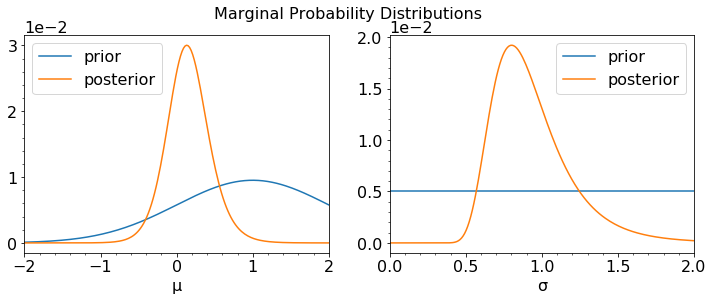

In [22]:
#Plot Marginal Priors and Posteriors
f, ax = pl.subplots(ncols=2, figsize=(12, 4))
df_μ.plot(x='μ', y='prior_prob', ax=ax[0], label='prior');
df_μ.plot(x='μ', y='post_prob', ax=ax[0], label='posterior')
df_σ.plot(x='σ', y='prior_prob', ax=ax[1], label='prior')
df_σ.plot(x='σ', y='post_prob', ax=ax[1], label='posterior');
f.suptitle('Marginal Probability Distributions', fontsize=16);

### Impact of Priors

* First wrap some of the above into helper functions to avoid rewriting the same code.

In [23]:
def compute_bayes_framework(data, priors_dict):
    # build grid:
    μ = np.linspace(-2, 2, num=200)
    σ = np.linspace(0, 2, num=200)
    df_b = pd.DataFrame([[μ_i, σ_i] for σ_i in σ for μ_i in μ],
                        columns=['μ', 'σ'])
    # compute/store distributions
    μ_prior = norm.logpdf(df_b.μ, priors_dict['μ_mean'],
                          priors_dict['μ_sd'])
    σ_prior = uniform.logpdf(df_b.σ, priors_dict['σ_lo'],
                             priors_dict['σ_hi'])
    df_b['log_prior_prob'] = μ_prior + σ_prior 
    df_b['prior_prob'] = np.exp(df_b.log_prior_prob
                                    - df_b.log_prior_prob.max())
    df_b['LL'] = np.sum(norm.logpdf(data.chl_l.values.reshape(1, -1),
                                    loc=df_b.μ.values.reshape(-1, 1),
                                    scale=df_b.σ.values.reshape(-1, 1)
                                   ), axis=1)
    df_b['log_post_prob'] = df_b.LL + df_b.log_prior_prob
    df_b['post_prob'] = np.exp(df_b.log_post_prob
                               - df_b.log_post_prob.max())
    return df_b


def plot_posterior(df_, ax1, ax2):
    df_.plot.hexbin(x='μ', y='σ', C='prior_prob',
                        cmap=cmo.algae_r, sharex=False, ax=ax1)
    df_.plot.hexbin(x='μ', y='σ', C='post_prob',
                         cmap=cmo.algae_r, sharex=False, ax=ax2);
    ax1.set_title('Prior Probability Distribution')
    ax2.set_title('Posterior Probability Distribution')
    
    
def plot_marginals(df_, ax1, ax2, plot_prior=True):
    df_μ = df_.groupby(['μ']).sum().drop('σ',
                                         axis=1)[['prior_prob',
                                                  'post_prob']
                                                ].reset_index()
    df_σ = df_.groupby(['σ']).sum().drop('μ',
                                         axis=1)[['prior_prob',
                                                  'post_prob']
                                                ].reset_index() 
    
    # Normalize Probability Distributions
    df_μ.prior_prob /= df_μ.prior_prob.max()
    df_μ.post_prob /= df_μ.post_prob.max()
    df_σ.prior_prob /= df_σ.prior_prob.max()
    df_σ.post_prob /= df_σ.post_prob.max()

    #Plot Marginal Priors and Posteriors
    if plot_prior:
        df_μ.plot(x='μ', y='prior_prob', ax=ax1, label='prior');
        df_σ.plot(x='σ', y='prior_prob', ax=ax2, label='prior')
    df_μ.plot(x='μ', y='post_prob', ax=ax1, label='posterior')
    df_σ.plot(x='σ', y='post_prob', ax=ax2, label='posterior');

Try two priors:
1. $\mu \sim \mathcal{N}(1, 1)$, $\sigma \sim \mathcal{U}(0, 2)$ - a weakly informative prior

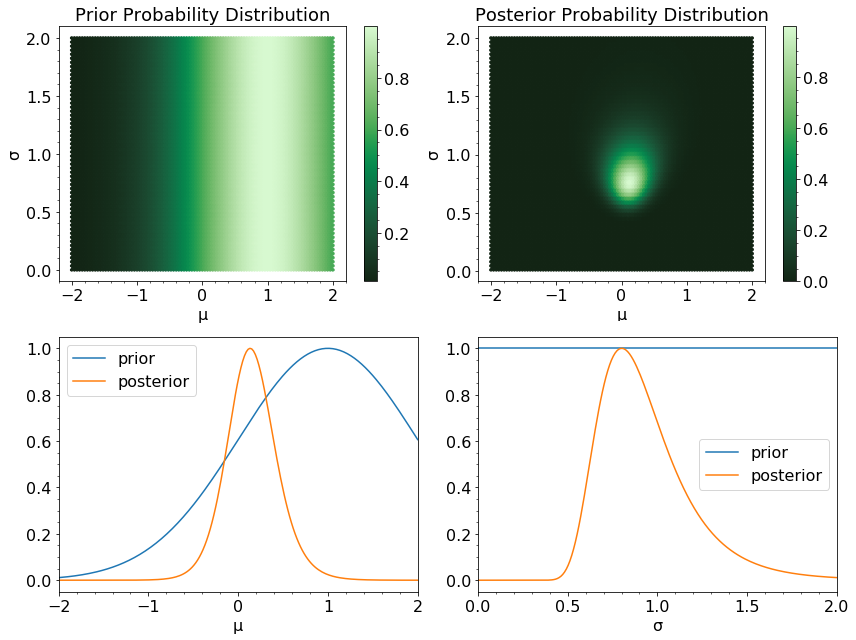

In [24]:
priors=dict(μ_mean=1, μ_sd=1, σ_lo=0, σ_hi=2)
df_grid_1 = compute_bayes_framework(df_data_s, priors_dict=priors)

f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_1, axp[0], axp[1])
plot_marginals(df_grid_1, axp[2], axp[3])
f.tight_layout()

2. $\mu \sim \mathcal{N}(-1.5, 0.1)$, $\sigma \sim \mathcal{U}(0, 2)$ - a strongly informative prior

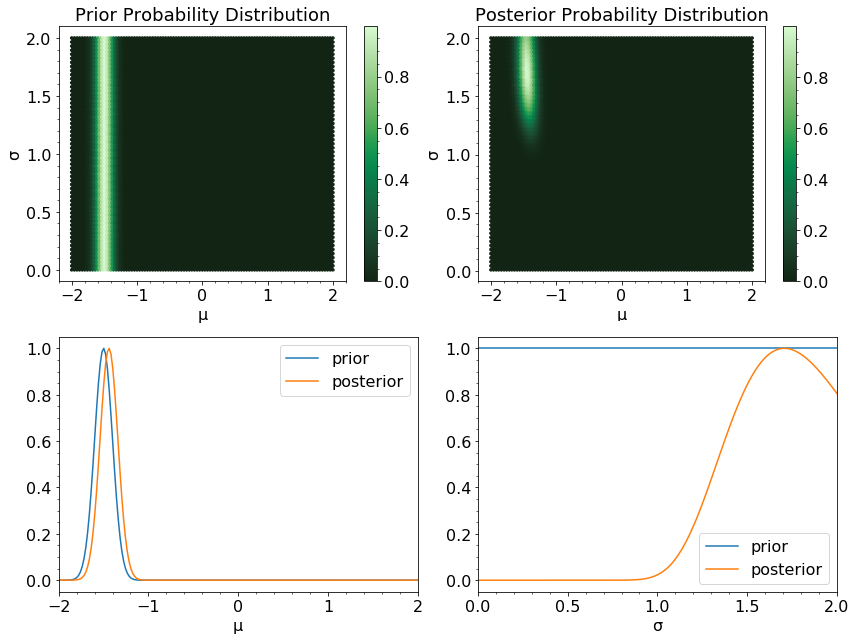

In [25]:
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
df_grid_2 = compute_bayes_framework(df_data_s, priors_dict=priors)

f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_2, axp[0], axp[1])
plot_marginals(df_grid_2, axp[2], axp[3])
f.tight_layout()

### <u>Impact of data set size</u>
* sub-sample size is now 500 samples,
* same two priors used

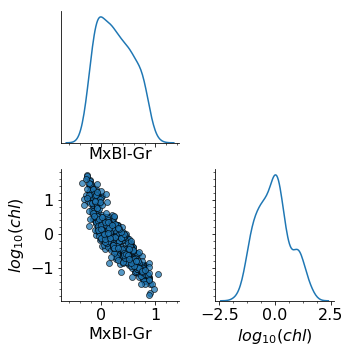

In [26]:
sample_N = 500

# compute the inference dataframe
df_data_s = df_data.dropna().sample(n=sample_N)

# display the new sub-sample
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

In [27]:
%%time
# set priors
priors=dict(μ_mean=1, μ_sd=1, σ_lo=0, σ_hi=2)
df_grid_3 = compute_bayes_framework(df_data_s, priors_dict=priors)

CPU times: user 1.28 s, sys: 929 ms, total: 2.21 s
Wall time: 2.08 s


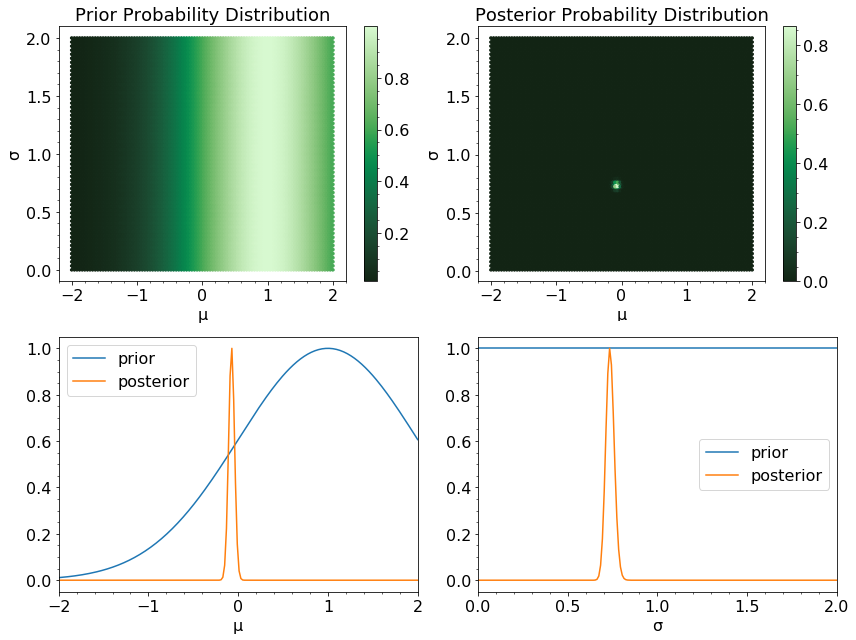

In [28]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_3, axp[0], axp[1])
plot_marginals(df_grid_3, axp[2], axp[3])
f.tight_layout()

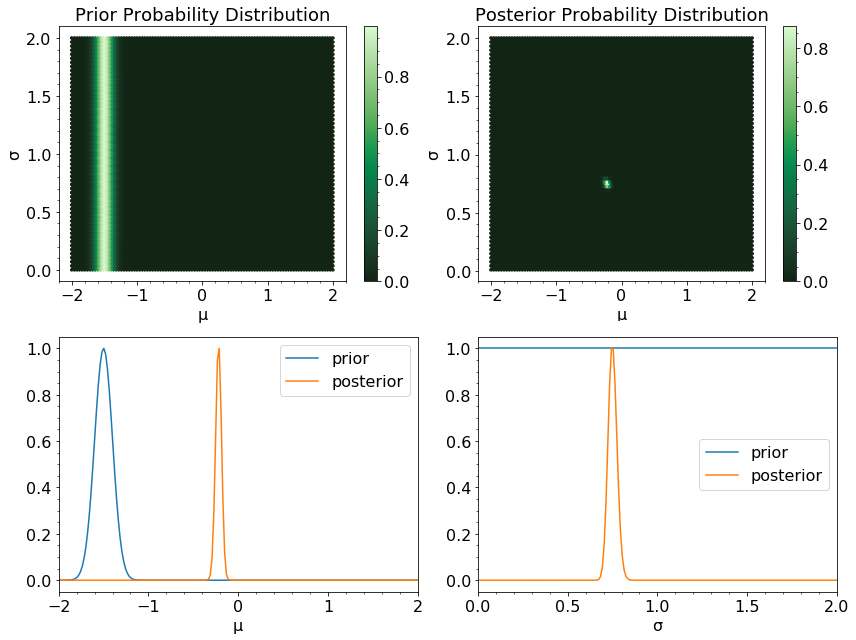

In [29]:
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
df_grid_4 = compute_bayes_framework(df_data_s, priors_dict=priors)

f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_4, axp[0], axp[1])
plot_marginals(df_grid_4, axp[2], axp[3])
f.tight_layout()

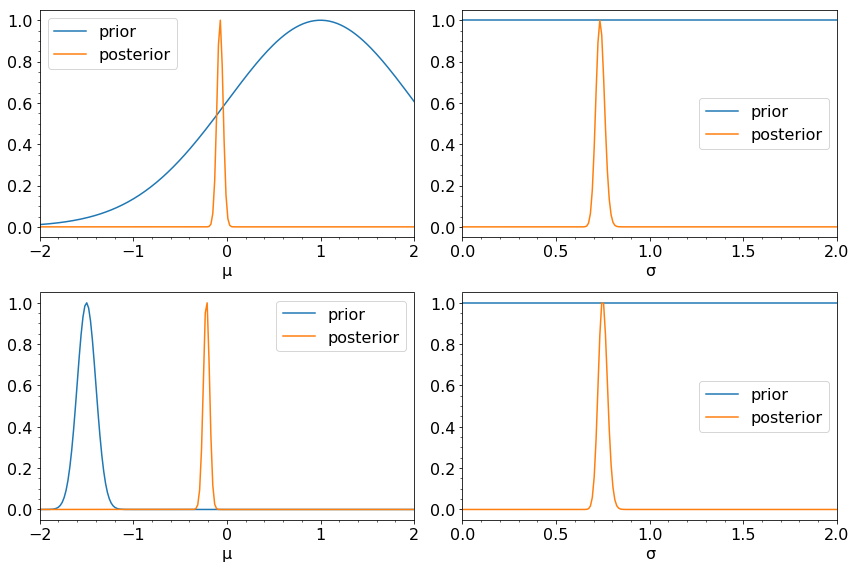

In [30]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 8))
axp = axp.ravel()
plot_marginals(df_grid_3, axp[0], axp[1])
plot_marginals(df_grid_4, axp[2], axp[3])
f.tight_layout()

##### Probabilistic modeling for the beginner
* <font color='red'>Starting easy: Inferring chlorophyll distribution</font>
    * ~~Grid approximation: computing probability everywhere~~
    * <font color='red'>Magical MCMC: Dealing with computational complexity</font>
    * PyMC3: Industrial grade MCMC

### <u>MCMC: Dealing with computational complexity</u>

* Grid approximation:
    * computationally intensive
    * impractical and often intractable at higher dimensions

    
* MCMC allows sampling where it probabilistically matters:
    * propose jump to new location in parameter space
    * compute probability of new location
    * compute ratio $\frac{new\ probability}{old\ probability}$
    * jump if ratio greater than one
    * otherwise jump if ratio greater than random number $\in [0, 1]$

In [31]:
def mcmc(d_data, μ_0=0.5, n_samples=1000):
    σ=0.75 # keep σ fixed for simplicity
    trace_μ = np.nan * np.ones(n_samples) # trace: where the sampler has been
    trace_μ[0] = μ_0 # start with a first guess
    for i in range(1, n_samples):
        proposed_μ = norm.rvs(loc=trace_μ[i-1], scale=0.1, size=1)
        lkl_prop = compute_likelihood(d_data, dict(μ=proposed_μ, σ=σ))
        lkl_curr = compute_likelihood(d_data, dict(μ=trace_μ[i-1], σ=σ))
        lkl_ratio = lkl_prop / lkl_curr
        if lkl_ratio > 1:
            # accept proposal
            trace_μ[i] = proposed_μ
        else:
            # evaluate low proba proposal
            if uniform.rvs(size=1, loc=0, scale=1) > lkl_ratio:
                # reject proposal
                trace_μ[i] = trace_μ[i-1]    
            else:
                # accept proposal
                trace_μ[i] = proposed_μ
    return trace_μ

In [35]:
 def compute_likelihood(d_data, param_dict):
    log_lkl = np.sum(norm.logpdf(d_data.chl_l.values.reshape(1, -1),
                                 loc=param_dict['μ'], scale=param_dict['σ']
                                ),
                     axis=1)
    lkl = np.exp(log_lkl)
    return lkl

#### Timing MCMC

In [52]:
%%time
mcmc_n_samples = 2000
trace = mcmc(d_data=df_data_s, n_samples=mcmc_n_samples)

CPU times: user 1.36 s, sys: 0 ns, total: 1.36 s
Wall time: 1.4 s


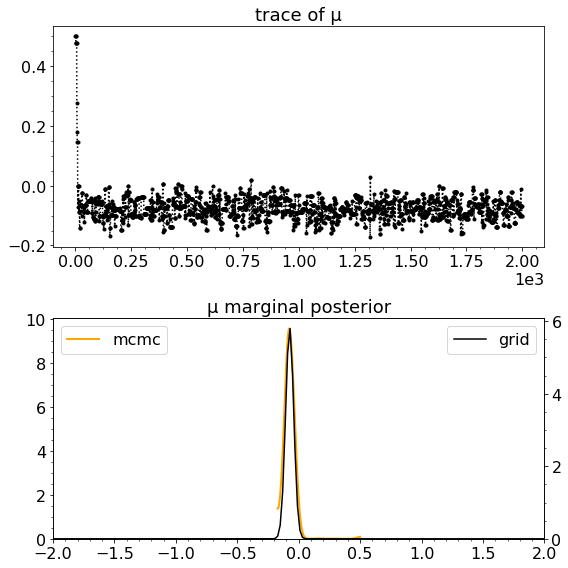

In [53]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
ax[0].plot(np.arange(mcmc_n_samples), trace, marker='.',
           ls=':', color='k')
ax[0].set_title('trace of μ')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(trace, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
df_μ = df_grid_3.groupby(['μ']).sum().drop('σ',
                                     axis=1)[['post_prob']
                                            ].reset_index()
ax2 = ax[1].twinx()
df_μ.plot(x='μ', y='post_prob', ax=ax2, color='k',
         label='grid',)
ax2.set_ylim(bottom=0);
ax2.legend(loc='upper right')
f.tight_layout()
f.savefig('./figJar/tutorial_1_mcmc.svg')

***And using all the data?***

In [39]:
%%time
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
try:
    df_grid_all_data= compute_bayes_framework(df_data, priors_dict=priors)
except MemoryError:
    print("OUT OF MEMORY!")
    print("--------------")

OUT OF MEMORY!
--------------
CPU times: user 2.4 s, sys: 6.83 s, total: 9.23 s
Wall time: 38.9 s


In [40]:
%%time
mcmc_n_samples = 2000
trace = mcmc(d_data=df_data, n_samples=mcmc_n_samples)

CPU times: user 2.19 s, sys: 3.65 ms, total: 2.19 s
Wall time: 2.29 s


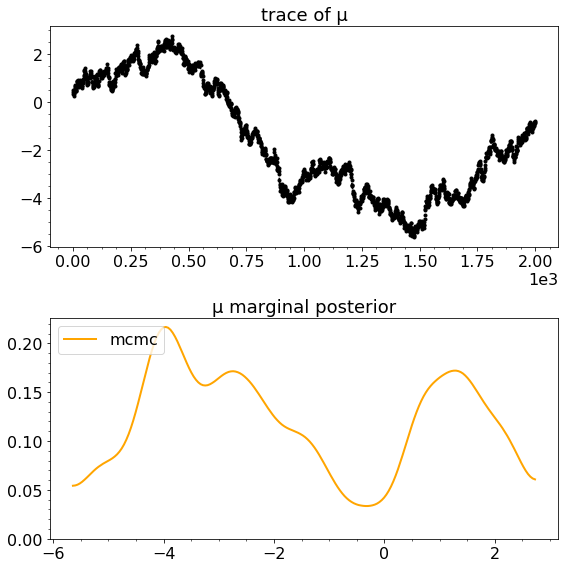

In [41]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
ax[0].plot(np.arange(mcmc_n_samples), trace, marker='.',
           ls=':', color='k')
ax[0].set_title('trace of μ')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(trace, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
f.tight_layout()

In [42]:
%%time
mcmc_n_samples = 20000
trace = mcmc(d_data=df_data, n_samples=mcmc_n_samples)

CPU times: user 22.3 s, sys: 0 ns, total: 22.3 s
Wall time: 22.3 s


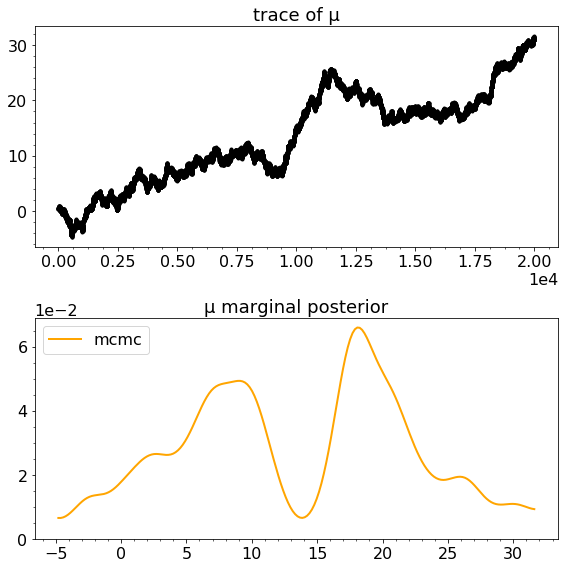

In [44]:
f, ax = pl.subplots(nrows=2, figsize=(8, 8))
ax[0].plot(np.arange(mcmc_n_samples), trace, marker='.',
           ls=':', color='k')
ax[0].set_title('trace of μ')
ax[1].set_title('μ marginal posterior')
pm.plots.kdeplot(trace, ax=ax[1], label='mcmc',
                 color='orange', lw=2, zorder=1)
ax[1].legend(loc='upper left')
ax[1].set_ylim(bottom=0)
f.tight_layout()

What's going on? $\rightarrow$ highly autocorrelated trace makes for inadequate parameter space exploration and poor convergence

* Metropolis MCMC is easy to code up but very inefficient in converging
* Metropolis MCMC complexity: $O(D^2)$ where D is the problem's dimensionality

* **Hamiltonian Monte Carlo (HMC)** samplers work much better
* HMC complexity: $O(D^{\frac{5}{4}})$,
* Much faster convergence
* Well mixed traces are a signature and an easy diagnostic
* HMC does require a lot of tuning,
* Not practical for the inexperienced applied statistician or scientist

* A flavor of HMC the No-U-Turn Sampler (NUTS) automates a lot of this tuning
* NUTS is also scales well to complex problems with many parameters (1000's)
* **PyMC3** is a *Probabilistic Programming* library in Python that implements the NUTS sampler among others...

##### Probabilistic modeling for the beginner
* <font color='red'>Starting easy: Inferring chlorophyll distribution</font>
    * ~~Grid approximation: computing probability everywhere~~
    * ~~MCMC: how it works~~
    * <font color='red'>Probabilistic Programming with PyMC3: Industrial grade MCMC </font>

### <u>Probabilistic Programming with PyMC3</u>

* has relatively simple syntax
* easily used in conjuction with widely used python analytics libraries such as numpy and pandas

In [45]:
with pm.Model() as m1:
    μ_ = pm.Normal('μ', mu=1, sd=1)
    σ = pm.Uniform('σ', lower=0, upper=2)
    lkl = pm.Normal('likelihood', mu=μ_, sd=σ,
                    observed=df_data.chl_l.dropna().values)
    trace_m1 = pm.sample(2000, tune=1000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1305.68draws/s]


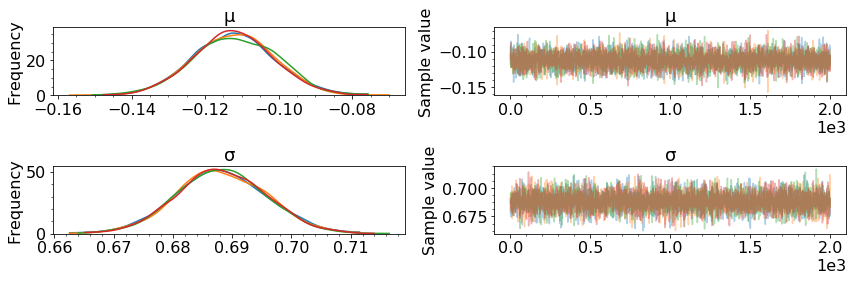

In [46]:
pm.traceplot(trace_m1);

In [47]:
pm.summary(trace_m1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,-0.112231,0.010878,0.000106,-0.134015,-0.091721,7883.463519,1.000007
σ,0.688089,0.007547,0.000084,0.672774,0.702465,8167.032698,0.999784


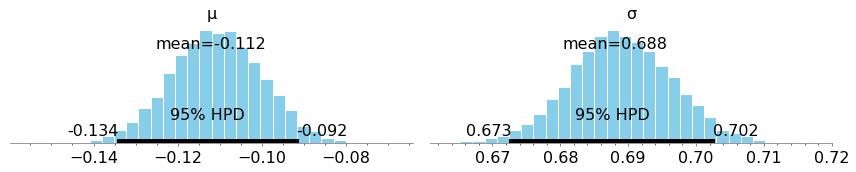

In [48]:
pm.plot_posterior(trace_m1, text_size=16);

In [49]:
posterior = pm.sample_posterior_predictive(trace_m1, model=m1,
                                           )

100%|██████████| 8000/8000 [00:09<00:00, 816.70it/s]


In [50]:
post_ = posterior['likelihood']
hpd = pm.hpd(post_)
mean_ = post_.mean(axis=0)

#### <u><font color='purple'>Tutorial Overview:</font></u>
* Probabilistic modeling for the beginner<br>
    $\rightarrow$~~The basics~~<br>
    $\rightarrow$~~Starting easy: inferring chlorophyll distribution~~<br>
    <font color='red'>$\rightarrow$Upgading to Regression: adding a predictor</font>

##### Probabilistic modeling for the beginner
* <font color='red'>Upgrading to Regression: Adding a predictor</font>
    * ~~Writing a regression model in PyMC3~~
    * ~~Do my priors make sense?~~
    * ~~Mining the posterior distribution
    * <font color='red'>Flavors of uncertainty</font>

### <u>Linear Regression: adding a predictor</u>

In [ ]:
df_data.head().T

Invert the blue/green ratio (green/blue) to make it more intuitive (blue baseline-corrected greenness increases with chlorophyll)

In [ ]:
df_data['Gr-MxBl'] = -1 * df_data['MxBl-Gr']

Make the regression parameters interpretable by centering the predictor variable

In [ ]:
df_data['Gr-MxBl_c'] = df_data['Gr-MxBl'] - df_data['Gr-MxBl'].mean()

In [ ]:
g3 = sb.PairGrid(df_data.loc[:, ['Gr-MxBl_c', 'chl_l']],
               diag_sharey=False)
g3.map_diag(sb.kdeplot, )
g3.map_offdiag(sb.scatterplot);
make_lower_triangle(g3)

Linear regression takes the form
$$log_{10}(chl) = \alpha + \beta \times \frac{Gr}{MxBl}$$

##### Upgrading to Regression: Adding a predictor
* <font color=red>Writing a regression model in PyMC3</font>
* Do my priors make sense?
* Mining the posterior distribution
* Flavors of uncertainty

In [ ]:
x = df_data.dropna()['Gr-MxBl_c'].values
y = df_data.dropna().chl_l.values

In [ ]:
with pm.Model() as m2:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=1)
    σ = pm.Uniform('σ', lower=0, upper=2)
    μ = α + β * x
    lkl = pm.Normal('likelihood', mu=μ, sd=σ,
                    observed=y)

In [ ]:
pm.model_to_graphviz(m2)

In [ ]:
<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>count</th>      <th>mean</th>      <th>std</th>      <th>min</th>      <th>25%</th>      <th>50%</th>      <th>75%</th>      <th>max</th>    </tr>  </thead>  <tbody>    <tr>      <th>MxBl-Gr</th>      <td>4453.0</td>      <td>0.274327</td>      <td>0.317070</td>      <td>-0.398402</td>      <td>0.011329</td>      <td>0.243728</td>      <td>0.520262</td>      <td>1.079671</td>    </tr>    <tr>      <th>chl_l</th>      <td>4127.0</td>      <td>-0.112459</td>      <td>0.687956</td>      <td>-1.920819</td>      <td>-0.632039</td>      <td>-0.116907</td>      <td>0.332438</td>      <td>1.891341</td>    </tr>  </tbody></table>

In [ ]:
prior = pm.sample_prior_predictive(samples=1000, model=m2)

In [ ]:
prior = pm.sample_prior_predictive(samples=1000, model=m2)

In [ ]:
x_dummy = np.linspace(-1.5, 1.5, num=50).reshape(-1, 1)

In [ ]:
α_prior = prior['α'].reshape(1, -1)
β_prior = prior['β'].reshape(1, -1)
chl_l_prior = α_prior + β_prior * x_dummy
chl_prior = np.power(10, chl_l_prior)

In [ ]:
with pm.Model() as m3:
    α = pm.Normal('α', mu=0, sd=0.5)
    β = pm.Normal('β', mu=0, sd=0.5)
    σ = pm.Uniform('σ', lower=0, upper=2)
    μ = α + β * x
    lkl = pm.Normal('likelihood', mu=μ, sd=σ,
                    observed=y)

In [ ]:
prior = pm.sample_prior_predictive(samples=1000, model=m3,
                                   vars=['α', 'β'])

In [ ]:
α_prior = prior['α'].reshape(1, -1)
β_prior = prior['β'].reshape(1, -1)
chl_l_prior = α_prior + β_prior * x_dummy
chl_prior = np.power(10, chl_l_prior)

In [ ]:
chl_prior.min(), chl_prior.max()

In [ ]:
with m3:
    trace_m3 = pm.sample(2000, tune=1000, chains=4)

In [ ]:
pm.traceplot(trace_m3);

##### Probabilistic modeling for the beginner 
* <font color='red'>Upgrading to Regression: Adding a predictor to estimate chl</font>
    * ~~Writing a regression model in PyMC3~~
    * ~~Do my priors make sense?~~
    * <font color='red'>Mining the posterior distribution</font>
    * Flavors of uncertainty

--o--

In [ ]:
g3 = sb.PairGrid(df_.loc[:, ['MxBl-Gr', 'chl_l', 'mxBlId']],
               hue='mxBlId', diag_sharey=False)
g3.map_diag(sb.kdeplot, )
g3.map_offdiag(sb.scatterplot);
make_lower_triangle(g3)

In [ ]:
g = sb.PairGrid(df_.loc[:, ['MxBl-Gr2', 'chl_l', 'mxBlId2']],
               hue='mxBlId2', diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.5, edgecolor='k')
g.add_legend();
make_lower_triangle(g)

#### Probabilistic modeling for the not-beginner
* More complicated models
    * polynomial regression
    * splines
    * empirical vs. semi-analytical: a useful dichotomy?
* Comparing models through information theory
* Multi-level models:
    * Pooled, unpooled and partially pooled models.
    * Hierarchical probabilistic models
    * Solving the regional vs. global quandary